In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from tqdm import tqdm
import matplotlib.pyplot as plt

from neuralop.models import FNO, UNO as UFNO

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from temp import check_torch
device = check_torch()

------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.4.0+cu121 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3090
------------------------------------------------------------


In [2]:
sec2year   = 365.25 * 24 * 60 * 60
psi2pascal = 6894.76
co2_rho    = 686.5266
mega       = 1e6

n_timesteps = 33
nx, ny, nz, nz_short  = 100, 100, 11, 5

indexMap = loadmat('data_100_100_11/G_cells_indexMap.mat', simplify_cells=True)['gci']
Grid = np.zeros((nx,ny,nz)).flatten(order='F')
Grid[indexMap] = 1
Grid = Grid.reshape(nx,ny,nz, order='F')
Tops = np.load('data_npy_100_100_11/tops_grid.npz')['tops']
print('Grid: {} | Tops: {}'.format(Grid.shape, Tops.shape))

Grid_short = Grid[:,:,5:10]
Grid_ext = np.repeat(np.expand_dims(Grid, 0), 33, axis=0)
Grid_short_ext = np.repeat(np.expand_dims(Grid_short, 0), 33, axis=0)
print('Grid_ext: {} | Grid_short_ext: {}'.format(Grid_ext.shape, Grid_short_ext.shape))

def apply_mask(x, imap=indexMap, mask_value=0.0):
    xx = mask_value*np.ones((nx,ny,nz)).flatten(order='F')
    xx[imap] = x.flatten(order='F')[imap]
    xx = xx.reshape((nx,ny,nz), order='F')
    return xx

Grid: (100, 100, 11) | Tops: (100, 100, 11)
Grid_ext: (33, 100, 100, 11) | Grid_short_ext: (33, 100, 100, 5)


In [7]:
dd = np.load('data/realization_0.npz')
for k in dd.keys():
    print(k, dd[k].shape)

xm (5, 100, 100, 5)
xc (33, 5)
xt (33, 1)
yy (33, 2, 100, 100, 5)


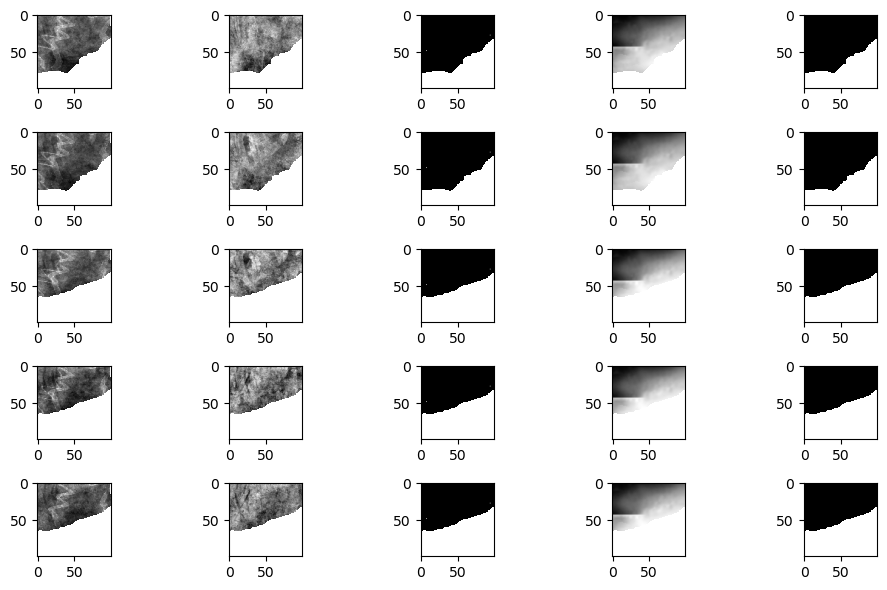

In [14]:
fig, axs = plt.subplots(5, 5, figsize=(10,6), sharex=True, sharey=True)
for i in range(5):
    for j in range(5):
        d = dd['xm'][j,:,:,i]
        m = np.ma.masked_where(Grid[:,:,i+5]==0, d)
        axs[i,j].imshow(m, cmap='gray')
plt.tight_layout()
plt.show()

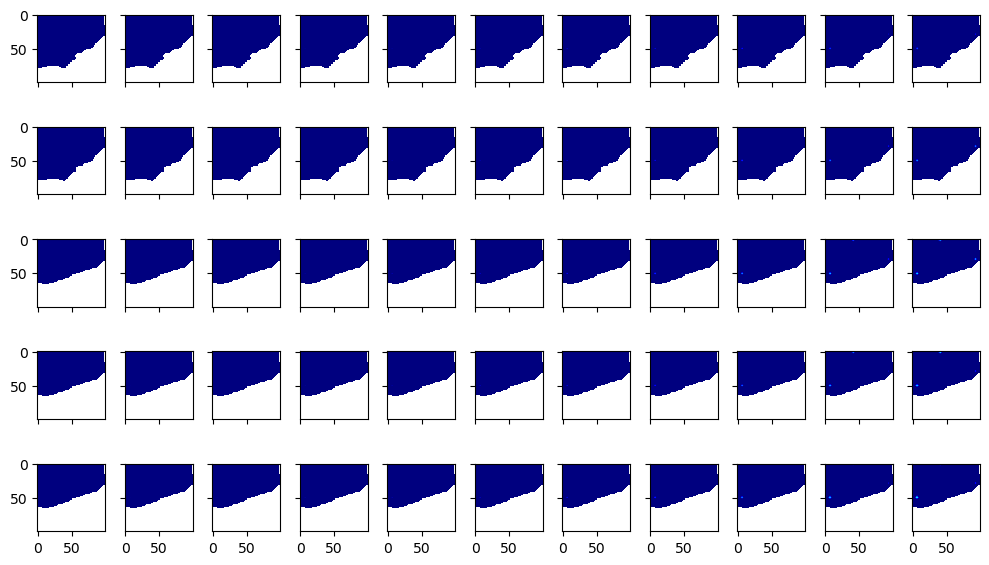

In [20]:
fig, axs = plt.subplots(5, 11, figsize=(10,6), sharex=True, sharey=True)
for i in range(5):
    for j in range(11):
        d = dd['yy'][j,1,:,:,i]
        m = np.ma.masked_where(Grid[:,:,i+5]==0, d)
        axs[i,j].imshow(m, cmap='jet', vmin=0, vmax=1)
plt.tight_layout()
plt.show()

In [ ]:
x_m_tensor = torch.tensor(xm, dtype=torch.float32)
x_c_tensor = torch.tensor(xc, dtype=torch.float32)
x_t_tensor = torch.tensor(xt, dtype=torch.float32)
y_tensor = torch.tensor(yy, dtype=torch.float32)
print('xm', x_m_tensor.shape)
print('xc', x_c_tensor.shape)
print('xt', x_t_tensor.shape)
print('yy', y_tensor.shape)

In [ ]:
class AdaptiveONet(nn.Module):
    def __init__(self, in_ch:int, out_ch:int=128, n_layers=5, activation=F.gelu, dropout=0.1,
                 transformer_num_layers:int=3, 
                 transformer_nhead:int=4,
                 transformer_dim_feedforward:int=1024, 
                 transformer_activation=F.gelu):
        super(AdaptiveONet, self).__init__()
        self.activation = activation
        self.dropout = nn.Dropout(dropout)
        self.lift = nn.Linear(in_ch, out_ch)
        self.norm = nn.LayerNorm(out_ch)
        self.layers = nn.ModuleList([nn.Linear(out_ch, out_ch) for _ in range(n_layers)])

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=out_ch, 
                nhead=transformer_nhead, 
                dim_feedforward=transformer_dim_feedforward, 
                activation=transformer_activation,
                batch_first=True),
            num_layers=transformer_num_layers)
        
    def forward(self, x):
        x = self.dropout(self.activation(self.norm(self.lift(x))))
        for layer in self.layers:
            x = self.dropout(self.activation(self.norm(layer(x))))
        x = self.transformer(x)
        return x

In [ ]:
class SqueezeExcite3d(nn.Module):
    def __init__(self, channels, ratio=4):
        super(SqueezeExcite3d, self).__init__()
        self.ratio = ratio
        self.squeeze = nn.AdaptiveAvgPool3d(1)
        self.excite1 = nn.Linear(channels, channels//ratio)
        self.excite2 = nn.Linear(channels//ratio, channels)

    def forward(self, x):
        b, c, _, _, _ = x.size()
        se_tensor = self.squeeze(x).view(b,c)
        se_tensor = F.relu(self.excite1(se_tensor))
        se_tensor = torch.sigmoid(self.excite2(se_tensor)).view(b,c,1,1,1)
        scaled_inputs = x * se_tensor.expand_as(x)
        return x + scaled_inputs

In [ ]:
class SeparableConvBlock3d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, activation=F.gelu):
        super(SeparableConvBlock3d, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size, padding=padding, groups=in_channels)
        self.saex = SqueezeExcite3d(out_channels)
        self.norm = nn.GroupNorm(out_channels, out_channels)
        self.actv = activation

    def forward(self, x):
        x = self.conv(x)
        x = self.saex(x)
        x = self.norm(x)
        x = self.actv(x)
        return x

In [ ]:
class SpatialEncoder(nn.Module):
    def __init__(self, in_ch:int=5, hidden_ch=[15,45,135], projection_ch:int=128, input_shape=(100,100,5),
                 kernel_size=3, padding=1, return_sequence:bool=True):
        super(SpatialEncoder, self).__init__()
        k, p = kernel_size, padding
        h, w, d = input_shape
        self.return_sequence = return_sequence
        self.conv1 = SeparableConvBlock3d(in_ch, hidden_ch[0], kernel_size=k, padding=p)
        self.conv2 = SeparableConvBlock3d(hidden_ch[0], hidden_ch[1], kernel_size=k, padding=p)
        self.conv3 = SeparableConvBlock3d(hidden_ch[1], hidden_ch[2], kernel_size=k, padding=p)
        self.pool1 = nn.AdaptiveMaxPool3d((h//2,w//2,d))
        self.pool2 = nn.AdaptiveMaxPool3d((h//4,w//4,d))
        self.pool3 = nn.AdaptiveMaxPool3d((h//8,w//8,d))
        self.project = nn.Linear(hidden_ch[2], projection_ch)

    def forward(self,x):
        z1 = self.conv1(x)
        z  = self.pool1(z1)

        z2 = self.conv2(z)
        z  = self.pool2(z2)

        z3 = self.conv3(z)
        z  = self.pool3(z3)

        z4 = self.project(z.permute(0,2,3,4,1)).permute(0,4,1,2,3)
        b, c, h, w, d = z4.shape
        z  = z4.reshape(b, c, h*w*d)
        
        return z if self.return_sequence else z, (z1,z2,z3,z4)

In [ ]:
class NeuralPix2Vid(nn.Module):
    def __init__(self):
        super(NeuralPix2Vid, self).__init__()
        self.m_branch = SpatialEncoder()
        self.c_branch = AdaptiveONet(in_ch=5)
        self.t_branch = AdaptiveONet(in_ch=1)
        self.z_neural = FNO(n_layers=5,
                            n_modes=((3,10)),
                            in_channels=128, 
                            lifting_channels=256, 
                            hidden_channels=256, 
                            projection_channels=256,
                            out_channels=2)
        self.y_projct = nn.Linear(720, 29128)

    def forward(self, x):
        x_m, x_c, x_t = x
        zm, hm = self.m_branch(x_m)
        zc = self.c_branch(x_c)
        zt = self.t_branch(x_t)
        
        zb = torch.einsum('bcp,btc->btcp', zm, zc)
        zo = torch.einsum('btc,btcp->btcp', zt, zb).permute(0,2,1,3)

        zn = self.z_neural(zo)
        zn = zn.permute(0,2,1,3)

        zy = self.y_projct(zn)

        b, t, c, p = zy.shape
        p = torch.zeros((b, t, 100, 100, 11)).view(b, t, -1)
        s = torch.zeros((b, t, 100, 100, 11)).view(b, t, -1)
        p[:,:,indexMap] = zy[:,:,0]
        s[:,:,indexMap] = zy[:,:,1]
        yy = torch.stack([p,s], dim=2).view(b, t, 2, 100, 100, 11)[...,5:10]

        return yy

In [ ]:
model = NeuralPix2Vid()
print('Neural-pix2vid # params: {:,}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

***
# TEMP TESTS

In [ ]:
branch_m = SpatialEncoder()
branch_c = AdaptiveONet(in_ch=5)
branch_t = AdaptiveONet(in_ch=1)
print('M# params: {:,}'.format(sum(p.numel() for p in branch_m.parameters() if p.requires_grad)))
print('C# params: {:,}'.format(sum(p.numel() for p in branch_c.parameters() if p.requires_grad)))
print('T# params: {:,}'.format(sum(p.numel() for p in branch_t.parameters() if p.requires_grad)))

zm, hm = branch_m(x_m_tensor)
zc = branch_c(x_c_tensor)
zt = branch_t(x_t_tensor)
print('zm: {} | zc: {} | zt: {}'.format(zm.shape, zc.shape, zt.shape))

zb = torch.einsum('bcp,btc->btcp', zm, zc)
zz = torch.einsum('btc,btcp->btcp', zt, zb).permute(0,2,1,3)
print(zz.shape)

In [ ]:
mode1, mode2 = 3, 10
ufno = UFNO(n_layers=5,
            uno_n_modes=[[mode1,mode2],[mode1,mode2],[mode1,mode2],[mode1,mode2],[mode1,mode2]],
            uno_out_channels=[128,256,512,256,128],
            uno_scalings=[[1,1],[1,1],[1,1],[1,1],[1,1]],
            in_channels=128, lifting_channels=256, hidden_channels=256, projection_channels=256, out_channels=2)

print('UFNO# params: {:,}'.format(sum(p.numel() for p in ufno.parameters() if p.requires_grad)))
zy = ufno(zz)
print(zy.shape)

fig, axs = plt.subplots(4, 2, figsize=(8,5), sharex=True, sharey=True)
for i in range(4):
    for j in range(2):
        ax = axs[i,j]
        d = zy[i,j].detach().numpy()
        ax.imshow(d, aspect='auto')
plt.tight_layout()
plt.show()

In [ ]:
fno = FNO(n_layers=5,
          n_modes=((3,10)),
          in_channels=128, lifting_channels=256, hidden_channels=256, projection_channels=256, out_channels=2)

print('FNO# params: {:,}'.format(sum(p.numel() for p in fno.parameters() if p.requires_grad)))
zy = fno(zz)
print(zy.shape)

fig, axs = plt.subplots(4, 2, figsize=(8,5), sharex=True, sharey=True)
for i in range(4):
    for j in range(2):
        ax = axs[i,j]
        d = zy[i,j].detach().numpy()
        ax.imshow(d, aspect='auto')
plt.tight_layout()
plt.show()

In [ ]:
zy = zz.permute(0,2,1,3)
print(zy.shape)

In [ ]:
fcQ = nn.Linear(720, 29128)

yh = fcQ(zy)
print(yh.shape)

In [ ]:
train_dataset = TensorDataset(x_m_tensor[:-10], x_c_tensor[:-10], x_t_tensor[:-10], y_tensor[:-10])
valid_dataset = TensorDataset(x_m_tensor[-10:], x_c_tensor[-10:], x_t_tensor[-10:], y_tensor[-10:])

trainloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=10, shuffle=False)

In [ ]:
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIMLoss
from torchmetrics.image import SpatialCorrelationCoefficient as SCCLoss
from torchmetrics.image import SpectralDistortionIndex as SDILoss
from torchmetrics.image import UniversalImageQualityIndex as UIQILoss
from torchmetrics.image import VisualInformationFidelity as VIFLoss

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self, alpha=0.8, beta=0.7):
        super(CustomLoss, self).__init__()
        self.ssim = SSIMLoss()
        self.mse  = nn.MSELoss()
        self.mae  = nn.L1Loss()
        self.alpha = alpha
        self.beta  = beta

    def forward(self, true, pred):
        ridge_loss = self.beta*self.mse(true, pred) + (1-self.beta)*self.mae(true, pred)
        visual_loss = 1-self.ssim(true, pred)
        total_loss = self.alpha*ridge_loss + (1-self.alpha)*visual_loss
        return total_loss

In [ ]:
model = NeuralPix2Vid().to(device)
print('# parameters: {:,}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = CustomLoss().to(device)

In [ ]:
epochs, monitor = 101, 10
train_loss, valid_loss = [], []
for epoch in range(epochs):
    # training
    epoch_train_loss = []
    model.train()
    for i, (xm, xw, xc, xt, y) in enumerate(trainloader):
        optimizer.zero_grad()
        xm = xm.to(device)
        xw = xw.to(device)
        xc = xc.to(device)
        xt = xt.to(device)
        yt = y.to(device)
        yh = model(xm, xw, xc, xt).to(device)
        loss = criterion(yt, yh)
        optimizer.step()
        epoch_train_loss.append(loss.item())
    train_loss.append(np.mean(epoch_train_loss))
    # validation
    model.eval()
    epoch_valid_loss = []
    with torch.no_grad():
        for i, (xmv, xwv, xcv, xtv, yv) in enumerate(validloader):
            xmv = xmv.to(device)
            xwv = xwv.to(device)
            xcv = xcv.to(device)
            xtv = xtv.to(device)
            yv = yv.to(device)
            yhv = model(xmv, xwv, xcv, xtv).to(device)
            loss = criterion(yv, yhv)
            epoch_valid_loss.append(loss.item())
    valid_loss.append(np.mean(epoch_valid_loss))
    # print
    if epoch % monitor == 0:
        print('Epoch: [{}/{}] | Loss: {:.4f} | Valid Loss: {:.4f}'.format(
            epoch+1, epochs, train_loss[-1], valid_loss[-1]))

torch.save(model.state_dict(), 'neuralpix2vid.pth')
pd.DataFrame({'train': train_loss, 'valid': valid_loss}).to_csv('neuralpix2vid_losses.csv', index=False)

***
# END